## Work
1. 試比較有 BN 在 Batch_size = 2, 16, 32, 128, 256 下的差異
2. 請嘗試將 BN 放在 Activation 之前，並比較訓練結果
3. 請於 BN 放在 Input Layer 後，並比較結果

In [6]:
import os
import keras
import itertools
import tensorflow as tf
# 不需使用 GPU, 將 GPU 設定為 "無"
# 使用第一張 GPU 卡
os.environ["CUDA_VISIBLE_DEVICES"] = " 0, 1 "
# 只使用 30% 的 GPU 記憶體
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.3)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

# 設定 Keras 使用的 TensorFlow Session
tf.keras.backend.set_session(sess)

In [7]:
train, test = keras.datasets.cifar10.load_data()

In [8]:
## 資料前處理
def preproc_x(x, flatten=True):
    # 資料前處理 - 標準化
    x = x / 255.
    if flatten:
        # 將資料從圖形 (RGB) 轉為向量 (Single Vector)
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        # 用np_utils裡的to_categorical來做one-hot encoding的轉換：
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [9]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
# 資料前處理 - X 標準化
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
# 資料前處理 -Y 轉成 onehot
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x) # 加入Batch Normalization，能夠將每一層的輸入/輸出做正規化
            '''
            參數:
            units=n_units: 建立有n_units個神經元的隱藏層
            kernel_regularizer: 權重(W)正規化(或稱 正則項)函數，作用是對權重矩陣加上懲罰性函數(Penalty)，以防止過度擬合(overfit)，參見 regularizer。
            activation='relu': 使用relu為激活函數
            '''
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x) # 加入Batch Normalization，能夠將每一層的輸入/輸出做正規化
            '''
            參數:
            units=n_units: 建立有n_units個神經元的隱藏層
            kernel_regularizer: 權重(W)正規化(或稱 正則項)函數，作用是對權重矩陣加上懲罰性函數(Penalty)，以防止過度擬合(overfit)，參見 regularizer。
            activation='relu': 使用relu為激活函數
            '''
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3   # 學習率
EPOCHS = 50 # 訓練50週期，訓練集所有樣本（數據、記錄）參與訓練一次爲一個週期
BATCH_SIZE = [2, 16, 32, 128, 256] # 訓練時每個批次的樣本數。訓練樣本數/批次樣本數 = 批次數（每個週期）
MOMENTUM = 0.95 # 動量

In [7]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for batchsize in BATCH_SIZE:
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, # 訓練資料。
              epochs=EPOCHS,     # 訓練EPOCHS週期，訓練集所有樣本（數據、記錄）參與訓練一次爲一個週期
              batch_size=batchsize,  # 訓練時每個批次的樣本數，訓練樣本數/批次樣本數 = 批次數（每個週期）
              validation_data=(x_test, y_test),  #驗證資料。
              shuffle=True)   # 每次epochs後，將訓練集打亂順序。

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512 

Epoch 46/50
50000/50000 [==============================] - 343s 7ms/step - loss: 2.2501 - accuracy: 0.1589 - val_loss: 397.6576 - val_accuracy: 0.1790
Epoch 47/50
50000/50000 [==============================] - 343s 7ms/step - loss: 2.2550 - accuracy: 0.1604 - val_loss: 56.5578 - val_accuracy: 0.1872
Epoch 48/50
50000/50000 [==============================] - 343s 7ms/step - loss: 2.2512 - accuracy: 0.1592 - val_loss: 36.0730 - val_accuracy: 0.2150
Epoch 49/50
50000/50000 [==============================] - 343s 7ms/step - loss: 2.2450 - accuracy: 0.1630 - val_loss: 55.8357 - val_accuracy: 0.1941
Epoch 50/50
50000/50000 [==============================] - 345s 7ms/step - loss: 2.2347 - accuracy: 0.1702 - val_loss: 59.4010 - val_accuracy: 0.2056
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3072)              0         
__________________________________

Epoch 41/50
50000/50000 [==============================] - 44s 886us/step - loss: 1.1520 - accuracy: 0.5917 - val_loss: 1.3677 - val_accuracy: 0.5254
Epoch 42/50
50000/50000 [==============================] - 44s 885us/step - loss: 1.1510 - accuracy: 0.5934 - val_loss: 1.3638 - val_accuracy: 0.5243
Epoch 43/50
50000/50000 [==============================] - 44s 886us/step - loss: 1.1425 - accuracy: 0.5964 - val_loss: 1.4122 - val_accuracy: 0.5082
Epoch 44/50
50000/50000 [==============================] - 44s 886us/step - loss: 1.1361 - accuracy: 0.5975 - val_loss: 1.4314 - val_accuracy: 0.5133
Epoch 45/50
50000/50000 [==============================] - 44s 887us/step - loss: 1.1346 - accuracy: 0.5972 - val_loss: 1.4682 - val_accuracy: 0.4935
Epoch 46/50
50000/50000 [==============================] - 44s 885us/step - loss: 1.1303 - accuracy: 0.5999 - val_loss: 1.3615 - val_accuracy: 0.5263
Epoch 47/50
50000/50000 [==============================] - 44s 886us/step - loss: 1.1338 - accuracy:

50000/50000 [==============================] - 8s 169us/step - loss: 0.5196 - accuracy: 0.8191 - val_loss: 1.9631 - val_accuracy: 0.4704
Epoch 31/50
50000/50000 [==============================] - 8s 170us/step - loss: 0.4991 - accuracy: 0.8271 - val_loss: 1.9504 - val_accuracy: 0.4733
Epoch 32/50
50000/50000 [==============================] - 8s 170us/step - loss: 0.4768 - accuracy: 0.8361 - val_loss: 2.0709 - val_accuracy: 0.4404
Epoch 33/50
50000/50000 [==============================] - 8s 169us/step - loss: 0.4696 - accuracy: 0.8369 - val_loss: 2.0820 - val_accuracy: 0.4587
Epoch 34/50
50000/50000 [==============================] - 8s 169us/step - loss: 0.4536 - accuracy: 0.8414 - val_loss: 2.2524 - val_accuracy: 0.4531
Epoch 35/50
50000/50000 [==============================] - 8s 168us/step - loss: 0.4389 - accuracy: 0.8494 - val_loss: 2.1315 - val_accuracy: 0.4582
Epoch 36/50
50000/50000 [==============================] - 8s 169us/step - loss: 0.4170 - accuracy: 0.8550 - val_loss:

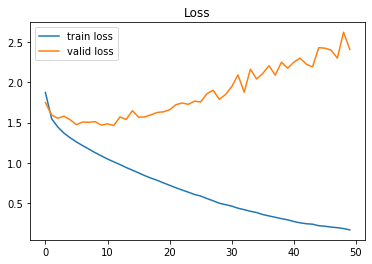

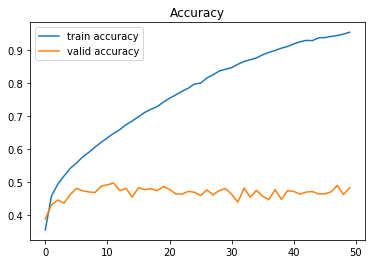

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

In [11]:
from keras.layers import BatchNormalization

def build_mlp2(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units,
                                   activation="relu",
                                   name="hidden_layer"+str(i+1))(input_layer)
            '''
            參數:
            units=n_units: 建立有n_units個神經元的隱藏層
            kernel_regularizer: 權重(W)正規化(或稱 正則項)函數，作用是對權重矩陣加上懲罰性函數(Penalty)，以防止過度擬合(overfit)，參見 regularizer。
            activation='relu': 使用relu為激活函數
            '''
        else:
            x = BatchNormalization()(x) # 加入Batch Normalization，能夠將每一層的輸入/輸出做正規化
            x = keras.layers.Dense(units=n_units,  
                                   activation="relu",
                                   name="hidden_layer"+str(i+1))(x)
            '''
            參數:
            units=n_units: 建立有n_units個神經元的隱藏層
            kernel_regularizer: 權重(W)正規化(或稱 正則項)函數，作用是對權重矩陣加上懲罰性函數(Penalty)，以防止過度擬合(overfit)，參見 regularizer。
            activation='relu': 使用relu為激活函數
            '''
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [12]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3   # 學習率
EPOCHS = 50 # 訓練50週期，訓練集所有樣本（數據、記錄）參與訓練一次爲一個週期
BATCH_SIZE = [2, 16, 32, 128, 256] # 訓練時每個批次的樣本數。訓練樣本數/批次樣本數 = 批次數（每個週期）
MOMENTUM = 0.95 # 動量

In [13]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for batchsize in BATCH_SIZE:
    model = build_mlp2(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, # 訓練資料。
              epochs=EPOCHS,     # 訓練EPOCHS週期，訓練集所有樣本（數據、記錄）參與訓練一次爲一個週期
              batch_size=batchsize,  # 訓練時每個批次的樣本數，訓練樣本數/批次樣本數 = 批次數（每個週期）
              validation_data=(x_test, y_test),  # 驗證資料。
              shuffle=True)   # 每次epochs後，將訓練集打亂順序。

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_3 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_4 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290

Epoch 47/50
50000/50000 [==============================] - 343s 7ms/step - loss: 2.1836 - accuracy: 0.1931 - val_loss: 135.9602 - val_accuracy: 0.1928
Epoch 48/50
50000/50000 [==============================] - 342s 7ms/step - loss: 2.1915 - accuracy: 0.1895 - val_loss: 44.7907 - val_accuracy: 0.2231
Epoch 49/50
50000/50000 [==============================] - 344s 7ms/step - loss: 2.1921 - accuracy: 0.1925 - val_loss: 66.1377 - val_accuracy: 0.2451
Epoch 50/50
50000/50000 [==============================] - 341s 7ms/step - loss: 2.1883 - accuracy: 0.1918 - val_loss: 126.1690 - val_accuracy: 0.2327
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
___________________________________________________

Epoch 43/50
50000/50000 [==============================] - 44s 881us/step - loss: 1.0236 - accuracy: 0.6324 - val_loss: 1.3795 - val_accuracy: 0.5309
Epoch 44/50
50000/50000 [==============================] - 44s 882us/step - loss: 1.0207 - accuracy: 0.6354 - val_loss: 1.4005 - val_accuracy: 0.5259
Epoch 45/50
50000/50000 [==============================] - 44s 882us/step - loss: 1.0059 - accuracy: 0.6422 - val_loss: 1.4297 - val_accuracy: 0.5176
Epoch 46/50
50000/50000 [==============================] - 44s 878us/step - loss: 1.0074 - accuracy: 0.6377 - val_loss: 1.3791 - val_accuracy: 0.5312
Epoch 47/50
50000/50000 [==============================] - 44s 875us/step - loss: 0.9967 - accuracy: 0.6429 - val_loss: 1.4480 - val_accuracy: 0.5173
Epoch 48/50
50000/50000 [==============================] - 44s 874us/step - loss: 0.9929 - accuracy: 0.6450 - val_loss: 1.4925 - val_accuracy: 0.5066
Epoch 49/50
50000/50000 [==============================] - 44s 878us/step - loss: 0.9843 - accuracy:

50000/50000 [==============================] - 8s 170us/step - loss: 0.4781 - accuracy: 0.8377 - val_loss: 2.0142 - val_accuracy: 0.4632
Epoch 35/50
50000/50000 [==============================] - 8s 170us/step - loss: 0.4598 - accuracy: 0.8446 - val_loss: 2.1756 - val_accuracy: 0.4336
Epoch 36/50
50000/50000 [==============================] - 8s 170us/step - loss: 0.4395 - accuracy: 0.8533 - val_loss: 2.2341 - val_accuracy: 0.4610
Epoch 37/50
50000/50000 [==============================] - 9s 170us/step - loss: 0.4257 - accuracy: 0.8562 - val_loss: 2.1620 - val_accuracy: 0.4519
Epoch 38/50
50000/50000 [==============================] - 9s 170us/step - loss: 0.4119 - accuracy: 0.8603 - val_loss: 2.0919 - val_accuracy: 0.4732
Epoch 39/50
50000/50000 [==============================] - 9s 171us/step - loss: 0.3958 - accuracy: 0.8684 - val_loss: 2.2899 - val_accuracy: 0.4562
Epoch 40/50
50000/50000 [==============================] - 9s 170us/step - loss: 0.3867 - accuracy: 0.8670 - val_loss:

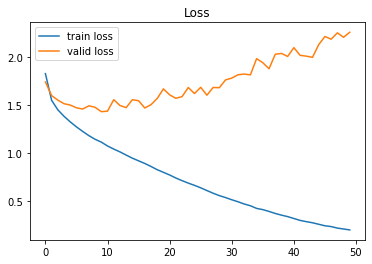

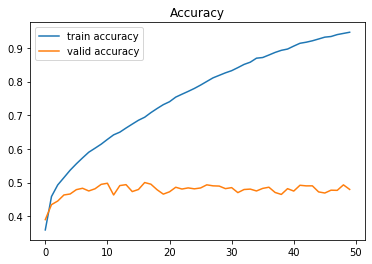

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

In [10]:
from keras.layers import BatchNormalization

def build_mlp3(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = BatchNormalization()(input_layer)
            x = keras.layers.Dense(units=n_units,
                                   activation="relu",
                                   name="hidden_layer"+str(i+1))(x)
            '''
            參數:
            units=n_units: 建立有n_units個神經元的隱藏層
            kernel_regularizer: 權重(W)正規化(或稱 正則項)函數，作用是對權重矩陣加上懲罰性函數(Penalty)，以防止過度擬合(overfit)，參見 regularizer。
            activation='relu': 使用relu為激活函數
            '''
        else:
            x = BatchNormalization()(x)#加入Batch Normalization，能夠將每一層的輸入/輸出做正規化
            x = keras.layers.Dense(units=n_units,  
                                   activation="relu",
                                   name="hidden_layer"+str(i+1))(x)
            '''
            參數:
            units=n_units: 建立有n_units個神經元的隱藏層
            kernel_regularizer: 權重(W)正規化(或稱 正則項)函數，作用是對權重矩陣加上懲罰性函數(Penalty)，以防止過度擬合(overfit)，參見 regularizer。
            activation='relu': 使用relu為激活函數
            '''
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [11]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3   # 學習率
EPOCHS = 50 # 訓練50週期，訓練集所有樣本（數據、記錄）參與訓練一次爲一個週期
BATCH_SIZE = [2, 16, 32, 128, 256] # 訓練時每個批次的樣本數。訓練樣本數/批次樣本數 = 批次數（每個週期）
MOMENTUM = 0.95 # 動量

In [12]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for batchsize in BATCH_SIZE:
    model = build_mlp3(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, # 訓練資料。
              epochs=EPOCHS,     # 訓練EPOCHS週期，訓練集所有樣本（數據、記錄）參與訓練一次爲一個週期
              batch_size=batchsize,  # 訓練時每個批次的樣本數，訓練樣本數/批次樣本數 = 批次數（每個週期）
              validation_data=(x_test, y_test),  # 驗證資料。
              shuffle=True)   # 每次epochs後，將訓練集打亂順序。

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]

Instructions for updating:
Colocations handled automatically by placer.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 3072)              12288     
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
_____________________________________________________

50000/50000 [==============================] - 16s 329us/step - loss: 0.6778 - accuracy: 0.7582 - val_loss: 1.4600 - val_accuracy: 0.5544
Epoch 38/50
50000/50000 [==============================] - 16s 329us/step - loss: 0.6699 - accuracy: 0.7607 - val_loss: 1.4741 - val_accuracy: 0.5458
Epoch 39/50
50000/50000 [==============================] - 16s 330us/step - loss: 0.6543 - accuracy: 0.7682 - val_loss: 1.5056 - val_accuracy: 0.5447
Epoch 40/50
50000/50000 [==============================] - 16s 330us/step - loss: 0.6450 - accuracy: 0.7704 - val_loss: 1.5047 - val_accuracy: 0.5455
Epoch 41/50
50000/50000 [==============================] - 16s 330us/step - loss: 0.6353 - accuracy: 0.7733 - val_loss: 1.5037 - val_accuracy: 0.5464
Epoch 42/50
50000/50000 [==============================] - 16s 330us/step - loss: 0.6249 - accuracy: 0.7775 - val_loss: 1.5315 - val_accuracy: 0.5456
Epoch 43/50
50000/50000 [==============================] - 16s 330us/step - loss: 0.6218 - accuracy: 0.7794 - va

50000/50000 [==============================] - 4s 74us/step - loss: 0.2058 - accuracy: 0.9369 - val_loss: 2.0719 - val_accuracy: 0.5202
Epoch 28/50
50000/50000 [==============================] - 4s 72us/step - loss: 0.1949 - accuracy: 0.9394 - val_loss: 2.1139 - val_accuracy: 0.5246
Epoch 29/50
50000/50000 [==============================] - 4s 73us/step - loss: 0.1805 - accuracy: 0.9440 - val_loss: 2.1328 - val_accuracy: 0.5212
Epoch 30/50
50000/50000 [==============================] - 4s 73us/step - loss: 0.1652 - accuracy: 0.9493 - val_loss: 2.1806 - val_accuracy: 0.5207
Epoch 31/50
50000/50000 [==============================] - 4s 73us/step - loss: 0.1569 - accuracy: 0.9519 - val_loss: 2.2187 - val_accuracy: 0.5159
Epoch 32/50
50000/50000 [==============================] - 4s 73us/step - loss: 0.1458 - accuracy: 0.9562 - val_loss: 2.2144 - val_accuracy: 0.5197
Epoch 33/50
50000/50000 [==============================] - 4s 73us/step - loss: 0.1456 - accuracy: 0.9550 - val_loss: 2.2923

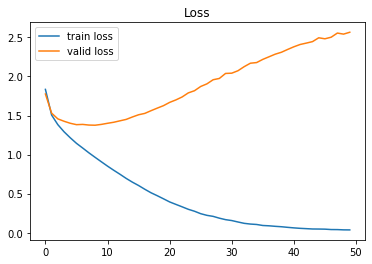

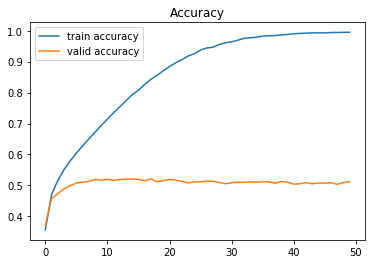

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()